In [1]:
import numpy as np
import scipy.optimize as spo
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from tqdm import tqdm

In [2]:
url = "https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/DataRotacion.csv"
df = pd.read_csv(url)
data_30 = df[df['angle'] == 30]
data_30

,h,angle,y,sigmay
20,10.0,30.0,0.0013,0.0015
21,20.0,30.0,0.0017,0.0015
22,30.0,30.0,0.0038,0.0015
23,40.0,30.0,0.0059,0.0015
24,50.0,30.0,0.0067,0.0015
25,60.0,30.0,0.0094,0.0015
26,70.0,30.0,0.0122,0.0015
27,80.0,30.0,0.0132,0.0015
28,90.0,30.0,0.0151,0.0015
29,100.0,30.0,0.0186,0.0015


In [3]:
def coriolis_desviacion(h, p, lamda, g):
    factor_constante = 2/3 * np.sqrt(2)
    cos_latitud = np.cos(np.radians(lamda))
    
    desviacion = factor_constante * p * cos_latitud * np.sqrt(h**3 / g)
    
    return desviacion


In [4]:
def chi_cuadrado(h, p, lamda, g, y, sigmay):
    desviacion_teorica = coriolis_desviacion(h, p, lamda, g)
    residuos = y - desviacion_teorica
    chi2 = np.sum((residuos / sigmay) ** 2)
    return chi2


In [5]:
h = data_30.iloc[:, 0].values
y = data_30.iloc[:, 2].values
sigmay = data_30.iloc[:, 3].values
lamda = data_30.iloc[:, 1].values
g = 9.8 
func_objetivo = lambda p: chi_cuadrado(h, p, lamda, g, y, sigmay)
resultado = spo.minimize(func_objetivo, x0=1, method='Nelder-Mead')

print(resultado.x)

[7.24315643e-05]


In [6]:

modelo=coriolis_desviacion(h,resultado.x,lamda,g)

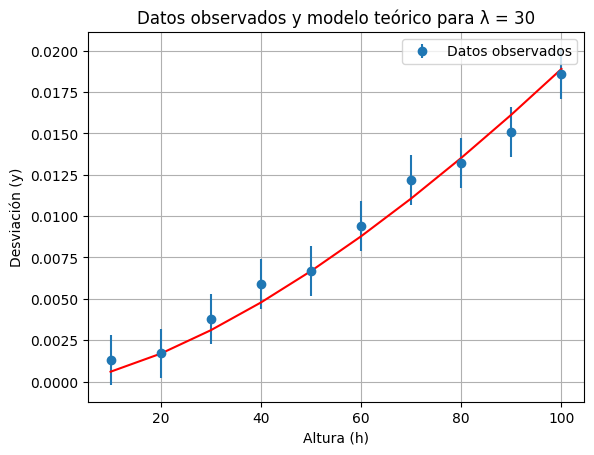

In [7]:
plt.errorbar(h, y, yerr=sigmay, fmt='o', label='Datos observados')
plt.plot(h,modelo,'r')
plt.xlabel('Altura (h)')
plt.ylabel('Desviación (y)')
plt.title('Datos observados y modelo teórico para λ = 30')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
N = 300
Gravedad = np.array([])
for i in range(N):
     Gravedad = np.append(9.81 + np.random.normal(loc=0,scale=1),Gravedad)
Omega=np.zeros(N)
for i in tqdm(range(N)):
   
    Y=y + np.random.normal( loc=0, scale=sigmay[0], size=len(y) )
    func_objetivoit = lambda p: chi_cuadrado(h, p, lamda, Gravedad[i], Y, sigmay)
    result_it=spo.minimize(func_objetivoit, x0=1e-5, method='Nelder-Mead')
    Omega[i]=result_it.x


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 24.32it/s]


In [9]:
np.mean(Gravedad)

9.812758887587025

In [60]:
H2,binsx,binsy = np.histogram2d(Omega,Gravedad,bins=(30,30))

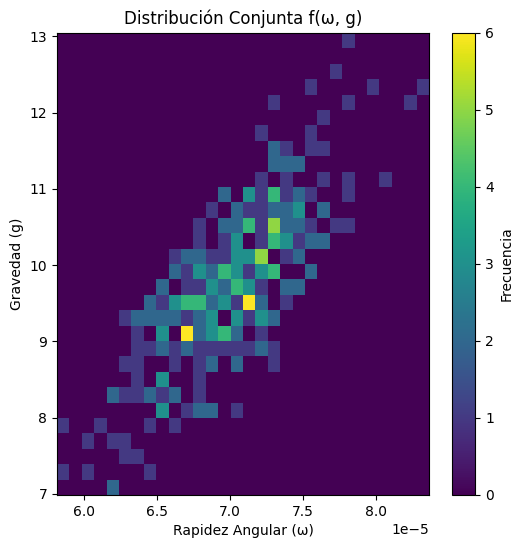

In [61]:

plt.figure(figsize = (6,6))
plt.imshow(H2, origin='lower', extent=[binsx[0], binsx[-1], binsy[0], binsy[-1]], aspect='auto', cmap='viridis')
plt.colorbar(label='Frecuencia')
plt.xlabel('Rapidez Angular (ω)')
plt.ylabel('Gravedad (g)')
plt.title('Distribución Conjunta f(ω, g)')
plt.show()

In [62]:
H1 = np.sum(H2,axis=1)

In [63]:
cs = np.cumsum(H1)
ij = np.searchsorted( cs, np.percentile(cs,16) )
ii = np.searchsorted( cs, np.percentile(cs,50) )
ji = np.searchsorted( cs, np.percentile(cs,84) )


In [132]:
def Minimizacion(h, lamda, Gravedad, Y, sigmay):
    Omega=np.zeros(len(Gravedad))
    
    for i in range(len(Gravedad)):
        
        func_objetivoit = lambda p: chi_cuadrado(h, p, lamda, Gravedad[i], Y, sigmay)
        result_it=spo.minimize(func_objetivoit, x0=1., method='Nelder-Mead')
        Omega[i]=result_it.x
    
    H2,binsx,binsy = np.histogram2d(Omega,Gravedad,bins=(30,30))
    H1 = np.sum(H2,axis=1)
    cs = np.cumsum(H1)
    ij = np.searchsorted( cs, np.percentile(cs,16) )
    ii = np.searchsorted( cs, np.percentile(cs,50) )
    ji = np.searchsorted( cs, np.percentile(cs,84) )
    error = 0.5*(binsx[1:]+binsx[:-1])
    sigma=np.std(Omega)
    
    return binsx[ii],binsx[ij],binsx[ji], error[ii],sigma

In [134]:
Lista=np.zeros([len(df['angle'].unique())+1, 5])
for i in tqdm(range(len(df['angle'].unique()))):
    lamda=df['angle'].unique()[i]
    data = df[df['angle']==lamda]
    y=data['y']
    sigmay=data.iloc[:, 3].values
    h=data['h']
    
    Y=y + np.random.normal( loc=0, scale=sigmay[0], size=len(y) )
    Lista[i]=np.array(Minimizacion(h, lamda, Gravedad, Y, sigmay))
    #for j in range(3):
        
        
        #Lista[i,j]=np.array(Minimizacion(h, lamda, Gravedad, Y, sigmay))[j]
Lista


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:06<00:00, 11.02s/it]


array([[7.08580017e-05, 6.35464986e-05, 7.74383545e-05, 7.12235769e-05,
        3.54738175e-06],
       [7.10129738e-05, 6.36776288e-05, 7.76147842e-05, 7.13797410e-05,
        3.55534297e-06],
       [7.33852386e-05, 6.57876333e-05, 8.02230835e-05, 7.37651189e-05,
        3.67169825e-06],
       [7.39455223e-05, 6.63081805e-05, 8.08191299e-05, 7.43273894e-05,
        3.69598394e-06],
       [7.05480576e-05, 6.32524490e-05, 7.71141052e-05, 7.09128380e-05,
        3.53338499e-06],
       [7.85350800e-05, 7.03652700e-05, 8.58879089e-05, 7.89435705e-05,
        3.93239328e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [135]:
#todos los datos
Y=y + np.random.normal( loc=0, scale=sigmay[0], size=len(y) )
Lista[-1]=Minimizacion(df['h'],df['angle'], Gravedad, Y, df['sigmay'])

In [136]:
Lista[:,3]

array([7.12235769e-05, 7.13797410e-05, 7.37651189e-05, 7.43273894e-05,
       7.09128380e-05, 7.89435705e-05, 7.89435705e-05])

In [138]:
Lista3=np.array([])
for i in range(len(Lista[:,3])):
    Lista3=np.append(Lista3,Lista[:,5][i]/(Lista[:,3][i]))
Lista3

IndexError: index 5 is out of bounds for axis 1 with size 5

In [ ]:
Lista[:,3]=Lista3
Lista

In [ ]:
eje_x=df['angle'].unique()
eje_x=np.append(eje_x,'Combined')
eje_x

In [ ]:
plt.scatter(eje_x,Lista[:,0])
plt.axhline(7.27e-5, linestyle = 'dashed', color = 'r', label="Día Solar")
plt.errorbar(eje_x,Lista[:,0],yerr=Lista[:,3], linestyle="None")